In [94]:
import json
import os
from collections import defaultdict
from datetime import datetime
from math import asin, cos, radians, sin, sqrt
from sshtunnel import SSHTunnelForwarder

import paramiko
import numpy as np
import pandas as pd
import rasterio
import sshtunnel

from pyproj import Transformer
from sqlalchemy import create_engine
from pyopensky.trino import Trino

In [95]:
LAT_MIN, LAT_MAX = 50.88385859501204322, 50.98427935836787128
LON_MIN, LON_MAX = 6.85029965503896943, 7.005 # 7.03641128126701965
ALT_MIN, ALT_MAX = 0, 750 # update from 700 m to 750 m, in line with CTR limit at 2500 ft plus margin (and accounting for Geoid Height)

TIME_BETWEEN_TRAJS = 30

# SERA.5005(f)(1) criteria
CONGESTED_ALERT_DISTANCE_M = 600      # alert distance wrt obstacles (should be 600)
CONGESTED_ALERT_DELTA_HEIGHT_M = 300   # delta height (should be 300)

# SERA.5005(f)(2) criteria
NONCONGESTED_ALERT_DISTANCE_M = 150 
NONCONGESTED_ALERT_DELTA_HEIGHT_M = 150  

CPA_MARGIN_M = 20 # allowance for lateral distance to obstacle
DIP_MARGIN_M = 20 # allowance for dip below minimum height (45m corresponds to GVA = 2)
N_MIN = 5

GEOID_HEIGHT_M = 47  # geoid height for Cologne

sshtunnel.SSH_TIMEOUT = 15.0
sshtunnel.TUNNEL_TIMEOUT = 15.0

# Setup OpenSky Network Trino credentials

In [54]:
OSN_secrets_json = './trino_secrets.json'
MYSQL_secrets_json = './mysql_secrets.json'

with open(OSN_secrets_json) as OSN_secrets:
  OSN_creds = json.load(OSN_secrets)

with open(MYSQL_secrets_json) as MYSQL_secrets:
  MYSQL_creds = json.load(MYSQL_secrets)

os.environ['OPENSKY_USERNAME'] = OSN_creds['OPENSKY_USERNAME']
os.environ['OPENSKY_PASSWORD'] = OSN_creds['OPENSKY_PASSWORD']

# Test connection with basic SQL query

In [55]:
trino = Trino()

query = "select * from operational_status_data4 limit 5"

df = trino.query(query, cached = False)

No credentials provided, falling back to browser authentication


Open the following URL in browser for the external authentication:
https://trino.opensky-network.org/oauth2/token/initiate/fe861ce2d01152533c871e3ec82b369b0f2facb9ab6932011786c03d4f3e1256


FINISHED: : 27.6% [00:12, 2.14%/s]
DOWNLOAD: 5.00lines [00:00, 125lines/s]


In [56]:
df

,sensors,rawmsg,icao24,mintime,maxtime,msgcount,subtypecode,unknowncapcode,unknownopcode,hasoperationaltcas,...,airplanewidth,version,nicsupplementa,positionnac,geometricverticalaccuracy,sourceintegritylevel,barometricaltitudeintegritycode,trackheadinginfo,horizontalreferencedirection,hour
0,"[(serial: -1408231736, mintime: 1656653136.679...",8d485122f82300020049b88c1acb,485122,1656653136.673,1656653136.679,1,0,False,False,1,...,None,2,False,9,-1,3,1,None,False,1656651600
1,"[(serial: -1408234983, mintime: 1656653136.701...",8d485122f82300020049b88c1acb,485122,1656653136.697,1656653136.701,1,0,False,False,1,...,None,2,False,9,-1,3,1,None,False,1656651600
2,"[(serial: -1408232917, mintime: 1656653136.704...",8d485122f82300020049b88c1acb,485122,1656653136.704,1656653136.704,1,0,False,False,1,...,None,2,False,9,-1,3,1,None,False,1656651600
3,"[(serial: -1408236446, mintime: 1656653136.725...",8d485122f82300020049b88c1acb,485122,1656653136.71,1656653136.725,1,0,False,False,1,...,None,2,False,9,-1,3,1,None,False,1656651600
4,"[(serial: -1408233674, mintime: 1656653136.742...",8d485122f82300020049b88c1acb,485122,1656653136.74,1656653136.742,1,0,False,False,1,...,None,2,False,9,-1,3,1,None,False,1656651600


# Send queries and merge results

In [96]:
start_str = "31/10/24"
end_str = "31/10/24"

start = datetime.strptime(start_str, '%d/%m/%y')
end = datetime.strptime(end_str, '%d/%m/%y')

# Modify start_date to be 00:00:00
start = start.replace(hour=0, minute=0, second=1, microsecond=0)
# Modify end_date to be 23:59:59
end = end.replace(hour=23, minute=59, second=59, microsecond=999999)

start_time = int(start.timestamp())
start_hour = start_time - (start_time % 3600)
end_time = int(end.timestamp())
end_hour = end_time - (end_time % 3600)

In [97]:
svdata4_query = (
        f"SELECT * FROM state_vectors_data4"
        f" WHERE icao24 LIKE '%'"
        f" AND time >= {start_time} AND time <= {end_time}"
        f" AND hour >= {start_hour} AND hour <= {end_hour}"
        f" AND lat >= {LAT_MIN} AND lat <= {LAT_MAX}"
        f" AND lon>= {LON_MIN} AND lon <= {LON_MAX}"
        f" AND geoaltitude >= {ALT_MIN} AND geoaltitude <= {ALT_MAX}"
        f" ORDER BY time"
    )

trino = Trino()

svdata4_df = trino.query(
    svdata4_query,
    cached=False,
    compress=True,
)

No credentials provided, falling back to browser authentication


Open the following URL in browser for the external authentication:
https://trino.opensky-network.org/oauth2/token/initiate/dc4c665276ef65adb7a052604a325a1837af0e04427c9cf69368938c8af5edea


FINISHED: : 99.8% [00:00, 320%/s]
DOWNLOAD: 4.68klines [00:00, 200klines/s]


In [7]:
# Save svdata4 pickle
svdata4_df.to_pickle('./OSN_pickles/svdata4df_new_2024-10-29_2024-10-30.pkl')

In [58]:
# OR Read a saved pickle

svdata4_df = pd.read_pickle('./OSN_pickles/svdata4df_new_2024-10-30.pkl')

In [59]:
len(svdata4_df.hour.unique())

9

In [9]:
len(svdata4_df.icao24.unique())

11

/var/folders/v_/0jkxx12x7r9_3szb050fks9m0000gn/T/ipykernel_15910/3399700428.py:7: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = plt.scatter(svdata4_df['lon'], svdata4_df['lat'], c=svdata4_df['geoaltitude'], cmap='Reds', alpha=0.7, marker='x', edgecolor='k')


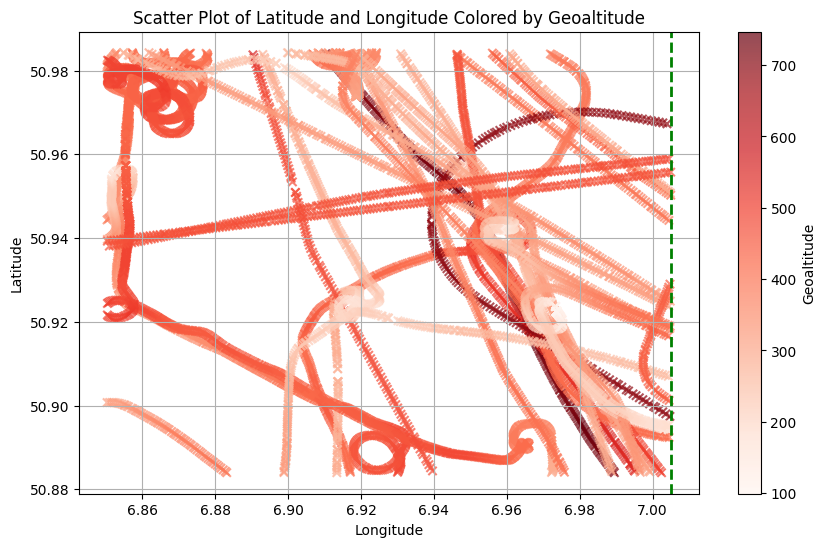

In [10]:
import matplotlib.pyplot as plt

# Assuming your dataframe is svdata4_df and it has 'lat', 'lon', and 'geoaltitude' columns
plt.figure(figsize=(10, 6))

# Create the scatter plot with colors based on 'geoaltitude'
sc = plt.scatter(svdata4_df['lon'], svdata4_df['lat'], c=svdata4_df['geoaltitude'], cmap='Reds', alpha=0.7, marker='x', edgecolor='k')

# Add a color bar to show the geoaltitude scale
cbar = plt.colorbar(sc)
cbar.set_label('Geoaltitude')

# Add a vertical line at lon = 7.005
plt.axvline(x=7.005, color='green', linestyle='--', linewidth=2)

# Add labels and title
plt.title('Scatter Plot of Latitude and Longitude Colored by Geoaltitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.grid(True)
plt.show()


In [98]:
icao_list = svdata4_df.icao24.unique()
icao24_str = ', '.join(f"'{item}'" for item in icao_list)

ops_sts_query = (
    f"SELECT icao24, mintime, maxtime, nacv, systemdesignassurance, version, positionnac, geometricverticalaccuracy, sourceintegritylevel, barometricaltitudeintegritycode  FROM operational_status_data4"
    f" WHERE icao24 IN ({icao24_str})"
    f" AND mintime >= {start_time} AND maxtime <= {end_time}"
    f" AND hour >= {start_hour} AND hour <= {end_hour}"
    f" ORDER by mintime"
)

print('Connecting to OSN database...')
trino = Trino()
ops_sts_df = trino.query(
    ops_sts_query,
    cached=False,
)

ops_sts_df['time'] = ops_sts_df['mintime'].astype('int64')

No credentials provided, falling back to browser authentication


Connecting to OSN database...
Open the following URL in browser for the external authentication:
https://trino.opensky-network.org/oauth2/token/initiate/7a5f317693f7b74f4ed348318891a0894c3cd37851c32cd42cfaa63f98aa2b59


FINISHED: : 100% [00:00, 433%/s] 
DOWNLOAD: 33.2klines [00:00, 915klines/s]


In [12]:
# Save ops_sts pickle
ops_sts_df.to_pickle('./OSN_pickles/opsstsdf_new_2024-10-29_2024-10-30.pkl')

In [99]:
# Initialize an empty DataFrame to hold the results
merged_df = pd.DataFrame()

# Loop over each unique 'icao24' in both dataframes
unique_icao24s = pd.concat([svdata4_df['icao24'], ops_sts_df['icao24']]).unique()

for icao24 in unique_icao24s:
    # Filter each dataframe by 'icao24'
    sub_df1 = svdata4_df[svdata4_df['icao24'] == icao24]
    sub_df2 = ops_sts_df[ops_sts_df['icao24'] == icao24]

    # Ensure both sub-dataframes are sorted by 'time'
    sub_df1 = sub_df1.sort_values('time')
    sub_df2 = sub_df2.sort_values('time')

    sub_df1['icao24'] = sub_df1['icao24'].astype('object')
    sub_df2['icao24'] = sub_df2['icao24'].astype('object')

    sub_df1['time'] = sub_df1['time'].astype('int64')
    sub_df2['time'] = sub_df2['time'].astype('int64')

    # Perform merge_asof on the filtered and sorted dataframes
    merged_sub_df = pd.merge_asof(sub_df1, sub_df2, on='time', by='icao24', direction='backward')
    
    # Append the result to the main dataframe
    merged_df = pd.concat([merged_df, merged_sub_df], ignore_index=True)


In [100]:
posdata4_query = (
    f"SELECT mintime, icao24, nic  FROM position_data4"
    f" WHERE icao24 IN ({icao24_str})"
    f" AND lat >= {LAT_MIN} AND lat <= {LAT_MAX}"
    f" AND lon>= {LON_MIN} AND lon <= {LON_MAX}"
    f" AND mintime >= {start_time} AND maxtime <= {end_time}"
    f" AND hour >= {start_hour} AND hour <= {end_hour}"
    f" ORDER by mintime"
)

print('Connecting to OSN database...')
trino = Trino()
posdata4_df = trino.query(
    posdata4_query,
    cached=False,
)

posdata4_df['time'] = posdata4_df['mintime'].astype('int64')

No credentials provided, falling back to browser authentication


Connecting to OSN database...
Open the following URL in browser for the external authentication:
https://trino.opensky-network.org/oauth2/token/initiate/173734b64c0c901342118581a75f5a491d231509f00484c948d56f6deab318dc


FINISHED: : 99.9% [00:00, 957%/s]
DOWNLOAD: 11.1klines [00:00, 1.52Mlines/s]


In [25]:
# Save ops_sts pickle
posdata4_df.to_pickle('./OSN_pickles/posdata4df_new_2024-10-29_2024-10-30.pkl')

In [117]:
# Initialize an empty DataFrame to hold the results
final_df = pd.DataFrame()

for icao24 in unique_icao24s:
    # Filter each dataframe by 'icao24'
    sub_df1 = merged_df[merged_df['icao24'] == icao24]
    sub_df2 = posdata4_df[posdata4_df['icao24'] == icao24]

    # Ensure both sub-dataframes are sorted by 'time'
    sub_df1 = sub_df1.sort_values('time')
    sub_df2 = sub_df2.sort_values('time')

    sub_df1['icao24'] = sub_df1['icao24'].astype('object')
    sub_df2['icao24'] = sub_df2['icao24'].astype('object')

    # Perform merge_asof on the filtered and sorted dataframes
    merged_sub_df = pd.merge_asof(sub_df1, sub_df2, on='time', by='icao24', direction='backward')
    
    # Append the result to the main dataframe
    final_df = pd.concat([final_df, merged_sub_df], ignore_index=True)

final_df = final_df.drop(columns=['hour', 'mintime_x', 'maxtime', 'mintime_y'])


# Add DEM ground elevation information

In [118]:
crs_transformer = Transformer.from_crs(4326, 25832, always_xy = True) # Transformer from WGS-84 to ETRS89-LAEA (3035 for EU-DEM v1.1, 25832 for LAS DEM)

def transform_coords(lon, lat):
    return crs_transformer.transform(lon, lat)

In [119]:
final_df['gnd_elev'] = np.nan

dem_src = rasterio.open('./resources/Cologne_DEM_merged_from_LAS_25x25.tif')

final_df['etrs89_x'], final_df['etrs89_y'] = zip(*final_df.apply(lambda row: transform_coords(row['lon'], row['lat']), axis=1))


In [120]:
def get_elevation(x, y, dem, default_value=None):
    try:
        row, col = dem.index(x, y)
        return dem.read(1)[row, col]
    except IndexError:
        return default_value

final_df['gnd_elev'] = final_df.apply(
    lambda row: get_elevation(row['etrs89_x'], row['etrs89_y'], dem_src, row.get('gnd_elev', None)), 
    axis=1
)

In [121]:
missing_elev_count = final_df['gnd_elev'].isnull().sum()
print(f"Number of rows with None or NaN in 'gnd_elev': {missing_elev_count}")
final_df = final_df.dropna(subset=['gnd_elev'])


Number of rows with None or NaN in 'gnd_elev': 22


# Add population density

In [122]:
final_df['pop_density'] = np.nan

pop_src = rasterio.open('./resources/GHS_POP_E2020_GLOBE_R2023A_4326_3ss_V1_0_Cologne.tif')

def get_population(lon, lat, pop_src):
    row, col = pop_src.index(lon, lat)
    return pop_src.read(1)[row, col]

final_df['pop_density'] = final_df.apply(lambda row: get_population(row['lon'], row['lat'], pop_src), axis=1)


# Process df with distance information

In [123]:
def haversine(pt1, pt2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    Returned units are in metres. Differs slightly from PostGIS geography
    distance, which uses a spheroid, rather than a sphere.
    """

    lat1, lon1 = pt1[0], pt1[1]
    lat2, lon2 = pt2[0], pt2[1]

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2.0) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2.0) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371000  # Radius of earth in m
    return c * r

In [108]:
final_df["prev_time"] = final_df.time.shift()
final_df['closest_obst_name'] = ''
final_df['inf_flt'] = False
final_df['inf_pt'] = False
final_df['gnd_inf_flt'] = False
final_df['gnd_inf_pt'] = False
final_df['min_hgt'] = np.nan
final_df['congested'] = final_df['pop_density'] > 2

map_time_traj = defaultdict(dict)

for icao, sfinal_df in final_df.groupby("icao24"):
    map_time_traj[icao][sfinal_df.iloc[0]["time"]] = icao + "_1"
    n_traj = 1
    for i in range(1, sfinal_df.shape[0]):
        time = sfinal_df.iloc[i]["time"]
        diff = abs(int(time) - int(sfinal_df.iloc[i]["prev_time"]))
        if diff > TIME_BETWEEN_TRAJS:
            n_traj += 1
        map_time_traj[icao][time] = icao + "_" + str(int(n_traj))

final_df['ref'] = final_df.apply(lambda x: map_time_traj[x.icao24][x.time], axis=1) + '_' + final_df.time.apply(lambda x: pd.to_datetime(x, unit='s').strftime("%d%m%y"))

# Add a distance column and compute cumulative along-track distance for each flight
final_df['dist'] = 0.0
for flight in final_df.ref.unique():
  first = True
  current = final_df[final_df['ref'].isin([flight])] # gets the trajectory of the current flight
  for row in current.itertuples():
    previous_pt = (0,0)
    previous_dist = 0
    if not(first):
      current_pt = (float(row.lat), float(row.lon))
      delta_dist = haversine(previous_pt, current_pt)
      final_df.loc[row[0],'dist'] = previous_dist + delta_dist
    previous_pt = (float(row.lat), float(row.lon))
    previous_dist = final_df.loc[row[0],'dist']
    first = False


# Load obstacle information and check min height

In [109]:
path_to_obstacles_json = './resources/LAC_obstacles_v1.csv'

obs_df = pd.read_csv(path_to_obstacles_json)

obs_df.rename(columns={'h': 'height_m'}, inplace=True)

obs_df = obs_df.sort_values(by=['height_m']) # sort obstacles by incresing height, to avoid that the min_hgt profil is wrong if a shorter obstacle comes after a taller one, in case the aircraft is within two obstacles clearance areas


In [110]:
# new. Test if this should not be done before adding the ref and distance info
final_df_bkp = final_df.copy()
final_df = final_df.reset_index(drop = True)

In [111]:
def update_closest_obstacle_xy(final_df, obstacles_df):

    # Extract the coordinates and obstacle heights
    final_coords = final_df[['etrs89_x', 'etrs89_y']].to_numpy()
    obstacle_coords = obstacles_df[['x', 'y']].to_numpy()
    obstacle_heights = obstacles_df['height_m'].to_numpy()
    obstacle_names = obstacles_df['LAC_Name'].to_numpy()
    obstacle_ground_elevs = obstacles_df['gnd_elev'].to_numpy()

    # Iterate over each point in final_df and calculate distances
    for i, (x_f, y_f) in enumerate(final_coords):

        radius = (CONGESTED_ALERT_DISTANCE_M if final_df.at[i, 'congested'] else NONCONGESTED_ALERT_DISTANCE_M)

        # Convert radius to a squared radius for comparison with squared distances (faster than computing square roots)
        squared_radius = radius ** 2

        # Calculate squared Euclidean distances to all obstacles
        distances_sq = (obstacle_coords[:, 0] - x_f) ** 2 + (obstacle_coords[:, 1] - y_f) ** 2
        
        # Filter obstacles within the radius
        within_radius = distances_sq <= squared_radius
        
        # If there are obstacles within the radius, find the tallest one
        if np.any(within_radius):
            # Get the indices of obstacles within the radius
            obstacles_in_radius_idx = np.where(within_radius)[0]
            
            # Find the index of the tallest obstacle within the radius
            tallest_idx = obstacles_in_radius_idx[np.argmax(obstacle_heights[obstacles_in_radius_idx])]
            
            # Update final_df with the tallest obstacle details
            tallest_obstacle_name = obstacle_names[tallest_idx]
            tallest_obstacle_height = obstacle_heights[tallest_idx]
            tallest_obstacle_elev = obstacle_ground_elevs[tallest_idx]
            
            final_df.at[i, 'closest_obst_name'] = tallest_obstacle_name

            final_df.at[i, 'min_hgt'] = (
                GEOID_HEIGHT_M + np.float32(tallest_obstacle_elev) +
                np.float32(tallest_obstacle_height) + 
                (CONGESTED_ALERT_DELTA_HEIGHT_M if final_df.at[i, 'congested'] else NONCONGESTED_ALERT_DELTA_HEIGHT_M)
            )
        else:
            final_df.at[i, 'closest_obst_name'] = 'ground'
            final_df.at[i, 'min_hgt'] = (CONGESTED_ALERT_DELTA_HEIGHT_M if final_df.at[i, 'congested'] else NONCONGESTED_ALERT_DELTA_HEIGHT_M)

    return final_df


In [112]:
final_df = update_closest_obstacle_xy(final_df, obs_df)

final_df['dip'] = final_df['min_hgt'] - final_df['geoaltitude']

# Add infraction information

In [113]:
# Rule for 'inf_pt'
final_df['inf_pt'] = final_df.apply(
    lambda row: 
        True if row['dip'] > 0 and row['closest_obst_name'] != 'ground' 
    else 
        False,
    axis=1
)

# Rule for 'gnd_inf_pt'
final_df['gnd_inf_pt'] = final_df.apply(
    lambda row: True if (row['dip'] > 0 and row['closest_obst_name'] == 'ground') else False,
    axis=1
)

# Group by 'ref' and update 'inf_flt' based on 'inf_pt'
final_df['inf_flt'] = final_df.groupby('ref')['inf_pt'].transform('any')

# Group by 'ref' and update 'gnd_inf_flt' based on 'gnd_inf_pt'
final_df['gnd_inf_flt'] = final_df.groupby('ref')['gnd_inf_pt'].transform('any')

final_df = final_df.drop(columns=['serials', 'nacv'])


In [77]:
final_df[final_df['gnd_inf_pt']].callsign.unique()

<ArrowExtensionArray>
['BPO316  ', 'CHX3    ', 'BPO311  ']
Length: 3, dtype: string[pyarrow]

In [114]:
missing_callsign = final_df['callsign'].isnull().sum()
print(f"Number of rows with None or NaN in 'callsign': {missing_callsign}")
final_df = final_df.dropna(subset=['callsign'])

Number of rows with None or NaN in 'callsign': 8


# Create infraction tables

In [79]:
inf_result = pd.DataFrame
gnd_inf_result = pd.DataFrame()

In [86]:
inf_pt_df = final_df[final_df.inf_pt].copy()

#lat, lon = obs_df.loc[obs_df['name'] == 'Ringturm', ['lat', 'lon']].values[0]

inf_pt_df['dist_to_obs'] = np.nan

inf_pt_df['dist_to_obs'] = inf_pt_df.apply(
    lambda x: haversine(
            (obs_df.loc[obs_df['LAC_Name'] == x['closest_obst_name'], 'lat'].iloc[0],
            obs_df.loc[obs_df['LAC_Name'] == x['closest_obst_name'], 'lon'].iloc[0]),
            (x['lat'], x['lon'])
    ) if not (x['closest_obst_name'] == 'ground') else np.nan, 
    axis=1
)

inf_pt_df['time'] = pd.to_datetime(inf_pt_df['time'], unit='s')
inf_pt_df = inf_pt_df.sort_values(by=['ref', 'closest_obst_name', 'time'])

inf_pt_df['time_diff'] = inf_pt_df.groupby(['ref', 'closest_obst_name'])['time'].diff()
inf_pt_df['group'] = (inf_pt_df['time_diff'] >= pd.Timedelta(seconds=30)).cumsum()

inf_grouped = inf_pt_df.groupby(['ref', 'closest_obst_name', 'group'])

inf_min_dist = inf_grouped.apply(lambda x: x.loc[x['dist_to_obs'].idxmin()]).reset_index(drop=True)

inf_max_dip = inf_grouped['dip'].max().reset_index()

group_size = inf_grouped.size().reset_index(name='n')

inf_result = inf_min_dist[['icao24', 'callsign', 'group', 'ref', 'closest_obst_name', 'time', 'lat', 'lon', 'dist_to_obs', 'congested', 'pop_density', 'systemdesignassurance', 'version', 'positionnac', 'sourceintegritylevel', 'nic']].copy()
inf_result = inf_result.merge(inf_max_dip, on=['ref', 'closest_obst_name', 'group'])
inf_result = inf_result.merge(group_size, on=['ref', 'closest_obst_name', 'group'])

inf_result.rename(columns={'dist_to_obs': 'cpa', 'dip': 'dip_max'}, inplace=True)

inf_result['entry_count'] = inf_result.groupby('ref').cumcount()
inf_result['inf_ref'] = inf_result['ref'].astype(str) + '_' + inf_result['entry_count'].astype(str)

inf_result['url'] = inf_result.apply(lambda row: "https://globe.adsbexchange.com/?icao=%s&lat=50.928&lon=6.947&zoom=13.2&showTrace=%s&timestamp=%s" % (
    row['icao24'],
    row['time'].strftime('%Y-%m-%d'),
    str(int(row['time'].timestamp()))
), axis=1)

inf_result = inf_result.reset_index(drop=True)

inf_result = inf_result.drop(columns=['entry_count', 'group'])

In [81]:
inf_result

,icao24,callsign,ref,closest_obst_name,time,lat,lon,cpa,congested,pop_density,systemdesignassurance,version,positionnac,sourceintegritylevel,nic,dip_max,n,inf_ref,url
0,3ddc04,CHX75,3ddc04_1_301024,In der Kreuzau 4,2024-10-30 16:50:59,50.907386,6.997910,241.050107,True,14.515580,2,2,10,3,9,32.260006,11,3ddc04_1_301024_0,https://globe.adsbexchange.com/?icao=3ddc04&la...
1,3ddc04,CHX75,3ddc04_1_301024,Pollonius,2024-10-30 16:50:32,50.922329,7.001877,199.242923,True,22.598281,2,2,10,3,9,74.119991,14,3ddc04_1_301024_1,https://globe.adsbexchange.com/?icao=3ddc04&la...
2,3ddc04,CHX75,3ddc04_2_301024,Koelner Dom,2024-10-30 17:37:50,50.942067,6.958008,86.155410,True,40.795096,2,2,10,3,9,422.199985,407,3ddc04_2_301024_0,https://globe.adsbexchange.com/?icao=3ddc04&la...
3,3ddc04,CHX75,3ddc04_2_301024,Lanxess Tower,2024-10-30 17:35:50,50.933899,6.969266,400.812560,True,4.950994,2,2,10,3,9,169.289987,14,3ddc04_2_301024_1,https://globe.adsbexchange.com/?icao=3ddc04&la...
4,3ddc04,CHX75,3ddc04_2_301024,Pollonius,2024-10-30 17:35:00,50.919342,7.002374,293.393286,True,11.951631,2,2,10,3,9,196.039991,13,3ddc04_2_301024_2,https://globe.adsbexchange.com/?icao=3ddc04&la...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,3e120c,DHYAM,3e120c_1_301024,Rodenkirchener Bruecke 1,2024-10-30 12:46:51,50.898029,6.991577,338.420714,True,7.953559,2,2,10,3,9,127.280002,6,3e120c_1_301024_6,https://globe.adsbexchange.com/?icao=3e120c&la...
92,3e120c,DHYAM,3e120c_1_301024,Rodenkirchener Bruecke 2,2024-10-30 12:46:45,50.895236,6.992569,425.232974,True,73.802161,2,2,10,3,9,127.230015,3,3e120c_1_301024_7,https://globe.adsbexchange.com/?icao=3e120c&la...
93,3e120c,DHYAM,3e120c_1_301024,Severinsbruecke,2024-10-30 12:48:01,50.928040,6.962882,552.907895,True,96.515369,2,2,10,3,9,102.180002,9,3e120c_1_301024_8,https://globe.adsbexchange.com/?icao=3e120c&la...
94,3e120c,DHYAM,3e120c_1_301024,St. Severin,2024-10-30 12:47:54,50.925355,6.965561,484.736758,True,57.979777,2,2,10,3,9,105.859995,7,3e120c_1_301024_9,https://globe.adsbexchange.com/?icao=3e120c&la...


Ground infractions

In [82]:
gnd_inf_pt_df = final_df[final_df.gnd_inf_pt & (final_df.dip >= 0) & (final_df.closest_obst_name == 'ground')].copy()

gnd_inf_pt_df['time'] = pd.to_datetime(gnd_inf_pt_df['time'], unit='s')
gnd_inf_pt_df = gnd_inf_pt_df.sort_values(by=['ref', 'time'])

gnd_inf_pt_df['time_diff'] = gnd_inf_pt_df.groupby(['ref'])['time'].diff()
gnd_inf_pt_df['group'] = (gnd_inf_pt_df['time_diff'] >= pd.Timedelta(seconds=30)).cumsum()

gnd_inf_grouped = gnd_inf_pt_df.groupby(['ref', 'group'])

gnd_inf_max_dip = gnd_inf_grouped.apply(lambda x: x.loc[x['dip'].idxmax()]).reset_index(drop=True)

group_size = gnd_inf_grouped.size().reset_index(name='n')

gnd_inf_result = gnd_inf_max_dip[['icao24', 'callsign', 'group', 'ref', 'closest_obst_name', 'time', 'lat', 'lon', 'dip', 'congested', 'pop_density', 'systemdesignassurance', 'version', 'positionnac', 'sourceintegritylevel', 'nic']].copy()

gnd_inf_result = gnd_inf_result.merge(group_size, on=['ref', 'group'])

gnd_inf_result.rename(columns={'dip': 'dip_max'}, inplace=True)

gnd_inf_result['entry_count'] = gnd_inf_result.groupby('ref').cumcount()
gnd_inf_result['inf_ref'] = gnd_inf_result['ref'].astype(str) + '_' + 'gnd_' + gnd_inf_result['entry_count'].astype(str)

gnd_inf_result['url'] = gnd_inf_result.apply(lambda row: "https://globe.adsbexchange.com/?icao=%s&lat=50.928&lon=6.947&zoom=13.2&showTrace=%s&timestamp=%s" % (
    row['icao24'],
    row['time'].strftime('%Y-%m-%d'),
    str(int(row['time'].timestamp()))
), axis=1)

gnd_inf_result = gnd_inf_result.reset_index(drop=True)

gnd_inf_result = gnd_inf_result.drop(columns=['entry_count', 'group'])



In [ ]:
gnd_inf_result.callsign.unique()

In [ ]:
gnd_inf_result.columns

In [ ]:
inf_result.columns

# Upload data to MySQL server

In [45]:
ed25519_key = paramiko.Ed25519Key(filename='./.ssh/id_ed25519')

# Set up the SSH tunnel with the RSA key
with SSHTunnelForwarder(
    (MYSQL_creds['SSH_ADDRESS'], 22),
    ssh_username=MYSQL_creds['SSH_USERNAME'],
    ssh_pkey=ed25519_key,  # Use the loaded RSA key
    remote_bind_address=(MYSQL_creds['REMOTE_BIND_ADDRESS'], MYSQL_creds['REMOTE_BIND_PORT']),
    allow_agent=False,
) as tunnel:
    
    print('connected')

    engstr =  'mysql+pymysql://' + MYSQL_creds['SSH_USERNAME'] + ':' + MYSQL_creds['PYANYWHERE_PASSWORD'] + '@127.0.0.1:' + str(tunnel.local_bind_port)+'/dme3$' + MYSQL_creds['PROD_DATABASE_NAME']

    engine = create_engine(engstr)

    print('step 1')
    final_df.to_sql(con=engine, name = MYSQL_creds['MAIN_PROD_TABLE_NAME'], if_exists='append')
    print('step 2')
    inf_result.to_sql(con=engine, name = MYSQL_creds['INF_PROD_TABLE_NAME'], if_exists='append')
    print('step 3')
    gnd_inf_result.to_sql(con=engine, name = MYSQL_creds['GNDINF_PROD_TABLE_NAME'], if_exists='append')

    print("Done")

connected
step 1
step 2
step 3
Done


# View results

In [ ]:
inf_result

# Load Distant data for tests

In [ ]:
with sshtunnel.SSHTunnelForwarder(
    (MYSQL_creds['SSH_ADDRESS']),
    ssh_username = MYSQL_creds['SSH_USERNAME'], ssh_password = MYSQL_creds['SSH_PASSWORD'],
    remote_bind_address = (MYSQL_creds['REMOTE_BIND_ADDRESS'], MYSQL_creds['REMOTE_BIND_PORT'])
) as tunnel:
    print('connected')

    engstr =  'mysql+pymysql://' + MYSQL_creds['SSH_USERNAME'] + ':' + MYSQL_creds['PYANYWHERE_PASSWORD'] + '@127.0.0.1:' + str(tunnel.local_bind_port)+'/dme3$' + MYSQL_creds['TEST_DATABASE_NAME']

    engine = create_engine(engstr)

    sql_query = """
    SELECT ref, lat, lon 
    FROM main_data_test
    WHERE positionnac >= 8
    """
    
    distant_df = pd.read_sql(sql_query, con=engine)

In [ ]:
SELECT 
    COLUMN_NAME, 
    IS_NULLABLE 
FROM 
    INFORMATION_SCHEMA.COLUMNS 
WHERE 
    TABLE_NAME = 'main_data_test' 
    AND TABLE_SCHEMA = 'testdatabase';

In [115]:
final_df[final_df.icao24 == '3ffb10']


,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,...,closest_obst_name,inf_flt,inf_pt,gnd_inf_flt,gnd_inf_pt,min_hgt,congested,ref,dist,dip
3358,1730383705,3ffb10,50.884506,6.90654,55.15118,342.07208,-2.60096,DMEML,False,False,...,ground,True,False,False,False,150.000000,False,3ffb10_1_311024,0.000000e+00,-337.68
3359,1730383706,3ffb10,50.884994,6.906281,55.15118,342.07208,-2.27584,DMEML,False,False,...,ground,True,False,False,False,150.000000,False,3ffb10_1_311024,5.695651e+06,-337.68
3360,1730383707,3ffb10,50.885468,6.906095,54.661945,341.906093,-0.97536,DMEML,False,False,...,ground,True,False,False,False,300.000000,True,3ffb10_1_311024,5.695701e+06,-187.68
3361,1730383708,3ffb10,50.885788,6.905872,54.661945,341.906093,-0.97536,DMEML,False,False,...,ground,True,False,False,False,300.000000,True,3ffb10_1_311024,5.695734e+06,-187.68
3362,1730383709,3ffb10,50.886065,6.905746,54.504365,340.709954,-1.6256,DMEML,False,False,...,ground,True,False,False,False,300.000000,True,3ffb10_1_311024,5.695763e+06,-180.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4145,1730384986,3ffb10,50.922409,7.002819,44.290013,120.735488,-0.65024,DMEML,False,False,...,Pollonius,False,False,False,False,508.459991,True,3ffb10_2_311024,5.700812e+06,-230.680009
4146,1730384987,3ffb10,50.922236,7.003403,44.824578,121.865978,-0.65024,DMEML,False,False,...,Pollonius,False,False,False,False,508.459991,True,3ffb10_2_311024,5.700800e+06,-230.680009
4147,1730384988,3ffb10,50.921997,7.003933,44.824578,121.865978,-0.97536,DMEML,False,False,...,Pollonius,False,False,False,False,508.459991,True,3ffb10_2_311024,5.700779e+06,-230.680009
4148,1730384989,3ffb10,50.921814,7.004304,44.66488,122.774877,-0.65024,DMEML,False,False,...,Pollonius,False,False,False,False,508.459991,True,3ffb10_2_311024,5.700763e+06,-230.680009


In [116]:
haversine((50.884506,6.90654),(50.884994,6.906281))

57.22414153650505

In [124]:
final_df["prev_time"] = final_df.time.shift()
final_df['closest_obst_name'] = ''
final_df['inf_flt'] = False
final_df['inf_pt'] = False
final_df['gnd_inf_flt'] = False
final_df['gnd_inf_pt'] = False
final_df['min_hgt'] = np.nan
final_df['congested'] = final_df['pop_density'] > 2

map_time_traj = defaultdict(dict)

for icao, sfinal_df in final_df.groupby("icao24"):
    map_time_traj[icao][sfinal_df.iloc[0]["time"]] = icao + "_1"
    n_traj = 1
    for i in range(1, sfinal_df.shape[0]):
        time = sfinal_df.iloc[i]["time"]
        diff = abs(int(time) - int(sfinal_df.iloc[i]["prev_time"]))
        if diff > TIME_BETWEEN_TRAJS:
            n_traj += 1
        map_time_traj[icao][time] = icao + "_" + str(int(n_traj))

final_df['ref'] = final_df.apply(lambda x: map_time_traj[x.icao24][x.time], axis=1) + '_' + final_df.time.apply(lambda x: pd.to_datetime(x, unit='s').strftime("%d%m%y"))


In [125]:
final_df[final_df.ref == '3ffb10_1_311024']

,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,...,pop_density,prev_time,closest_obst_name,inf_flt,inf_pt,gnd_inf_flt,gnd_inf_pt,min_hgt,congested,ref
3380,1730383705,3ffb10,50.884506,6.90654,55.15118,342.07208,-2.60096,DMEML,False,False,...,0.000000,1.730376e+09,,False,False,False,False,NaN,False,3ffb10_1_311024
3381,1730383706,3ffb10,50.884994,6.906281,55.15118,342.07208,-2.27584,DMEML,False,False,...,0.000000,1.730384e+09,,False,False,False,False,NaN,False,3ffb10_1_311024
3382,1730383707,3ffb10,50.885468,6.906095,54.661945,341.906093,-0.97536,DMEML,False,False,...,11.570889,1.730384e+09,,False,False,False,False,NaN,True,3ffb10_1_311024
3383,1730383708,3ffb10,50.885788,6.905872,54.661945,341.906093,-0.97536,DMEML,False,False,...,11.570889,1.730384e+09,,False,False,False,False,NaN,True,3ffb10_1_311024
3384,1730383709,3ffb10,50.886065,6.905746,54.504365,340.709954,-1.6256,DMEML,False,False,...,16.418666,1.730384e+09,,False,False,False,False,NaN,True,3ffb10_1_311024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3613,1730383938,3ffb10,50.946808,6.853093,48.176795,276.74558,2.60096,DMEML,False,False,...,27.696866,1.730384e+09,,False,False,False,False,NaN,True,3ffb10_1_311024
3614,1730383939,3ffb10,50.946854,6.852574,47.096217,276.271077,3.2512,DMEML,False,False,...,27.696866,1.730384e+09,,False,False,False,False,NaN,True,3ffb10_1_311024
3615,1730383940,3ffb10,50.946899,6.851757,46.482514,275.079608,4.8768,DMEML,False,False,...,0.000000,1.730384e+09,,False,False,False,False,NaN,False,3ffb10_1_311024
3616,1730383941,3ffb10,50.946909,6.85112,45.376177,273.900494,5.85216,DMEML,False,False,...,0.000000,1.730384e+09,,False,False,False,False,NaN,False,3ffb10_1_311024


In [126]:
final_df_bak = final_df.copy()

In [131]:
final_df = final_df_bak.copy()

In [130]:
# Add a distance column and compute cumulative along-track distance for each flight
final_df['dist'] = 0.0
for flight in final_df.ref.unique():
  first = True
  current = final_df[final_df['ref'].isin([flight])] # gets the trajectory of the current flight
  for row in current.itertuples():
    previous_pt = (0,0)
    previous_dist = 0
    if not(first):
      current_pt = (float(row.lat), float(row.lon))
      delta_dist = haversine(previous_pt, current_pt)
      final_df.loc[row[0],'dist'] = previous_dist + delta_dist
    previous_pt = (float(row.lat), float(row.lon))
    previous_dist = final_df.loc[row[0],'dist']
    first = False

In [128]:
final_df[final_df.ref == '3ffb10_1_311024']

,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,...,prev_time,closest_obst_name,inf_flt,inf_pt,gnd_inf_flt,gnd_inf_pt,min_hgt,congested,ref,dist
3380,1730383705,3ffb10,50.884506,6.90654,55.15118,342.07208,-2.60096,DMEML,False,False,...,1.730376e+09,,False,False,False,False,NaN,False,3ffb10_1_311024,0.000000e+00
3381,1730383706,3ffb10,50.884994,6.906281,55.15118,342.07208,-2.27584,DMEML,False,False,...,1.730384e+09,,False,False,False,False,NaN,False,3ffb10_1_311024,5.695651e+06
3382,1730383707,3ffb10,50.885468,6.906095,54.661945,341.906093,-0.97536,DMEML,False,False,...,1.730384e+09,,False,False,False,False,NaN,True,3ffb10_1_311024,5.695701e+06
3383,1730383708,3ffb10,50.885788,6.905872,54.661945,341.906093,-0.97536,DMEML,False,False,...,1.730384e+09,,False,False,False,False,NaN,True,3ffb10_1_311024,5.695734e+06
3384,1730383709,3ffb10,50.886065,6.905746,54.504365,340.709954,-1.6256,DMEML,False,False,...,1.730384e+09,,False,False,False,False,NaN,True,3ffb10_1_311024,5.695763e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3613,1730383938,3ffb10,50.946808,6.853093,48.176795,276.74558,2.60096,DMEML,False,False,...,1.730384e+09,,False,False,False,False,NaN,True,3ffb10_1_311024,5.701870e+06
3614,1730383939,3ffb10,50.946854,6.852574,47.096217,276.271077,3.2512,DMEML,False,False,...,1.730384e+09,,False,False,False,False,NaN,True,3ffb10_1_311024,5.701870e+06
3615,1730383940,3ffb10,50.946899,6.851757,46.482514,275.079608,4.8768,DMEML,False,False,...,1.730384e+09,,False,False,False,False,NaN,False,3ffb10_1_311024,5.701866e+06
3616,1730383941,3ffb10,50.946909,6.85112,45.376177,273.900494,5.85216,DMEML,False,False,...,1.730384e+09,,False,False,False,False,NaN,False,3ffb10_1_311024,5.701860e+06


In [133]:
final_df[final_df['ref'].isin(['3ffb10_1_311024'])]

,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,...,pop_density,prev_time,closest_obst_name,inf_flt,inf_pt,gnd_inf_flt,gnd_inf_pt,min_hgt,congested,ref
3380,1730383705,3ffb10,50.884506,6.90654,55.15118,342.07208,-2.60096,DMEML,False,False,...,0.000000,1.730376e+09,,False,False,False,False,NaN,False,3ffb10_1_311024
3381,1730383706,3ffb10,50.884994,6.906281,55.15118,342.07208,-2.27584,DMEML,False,False,...,0.000000,1.730384e+09,,False,False,False,False,NaN,False,3ffb10_1_311024
3382,1730383707,3ffb10,50.885468,6.906095,54.661945,341.906093,-0.97536,DMEML,False,False,...,11.570889,1.730384e+09,,False,False,False,False,NaN,True,3ffb10_1_311024
3383,1730383708,3ffb10,50.885788,6.905872,54.661945,341.906093,-0.97536,DMEML,False,False,...,11.570889,1.730384e+09,,False,False,False,False,NaN,True,3ffb10_1_311024
3384,1730383709,3ffb10,50.886065,6.905746,54.504365,340.709954,-1.6256,DMEML,False,False,...,16.418666,1.730384e+09,,False,False,False,False,NaN,True,3ffb10_1_311024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3613,1730383938,3ffb10,50.946808,6.853093,48.176795,276.74558,2.60096,DMEML,False,False,...,27.696866,1.730384e+09,,False,False,False,False,NaN,True,3ffb10_1_311024
3614,1730383939,3ffb10,50.946854,6.852574,47.096217,276.271077,3.2512,DMEML,False,False,...,27.696866,1.730384e+09,,False,False,False,False,NaN,True,3ffb10_1_311024
3615,1730383940,3ffb10,50.946899,6.851757,46.482514,275.079608,4.8768,DMEML,False,False,...,0.000000,1.730384e+09,,False,False,False,False,NaN,False,3ffb10_1_311024
3616,1730383941,3ffb10,50.946909,6.85112,45.376177,273.900494,5.85216,DMEML,False,False,...,0.000000,1.730384e+09,,False,False,False,False,NaN,False,3ffb10_1_311024
